In [1]:
import os
import json
import numpy as np
import pandas as pd
import scipy

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from src.data_loader import Shifted_Data_Loader
from src.plot import orig_vs_transformed as plot_ovt
from src.plot import enc_dec_samples
from src.models import GResNet,EDense
from src.config import get_config
from src.trainer import Trainer
from src.utils import prepare_dirs_and_logger
from keras.datasets import fashion_mnist,mnist
from keras.layers import Dense
from keras.models import Model
# from tabulate import tabulate

Using TensorFlow backend.


In [2]:
config,_ = get_config()
setattr(config, 'batch_size', 512)
setattr(config, 'dataset', 'mnist')
setattr(config, 'epochs', 100)
setattr(config, 'enc_layers', [3000,2000])
setattr(config, 'dec_blocks', [4,2,1])
setattr(config, 'z_dim', 10)
setattr(config, 'xcov', 1000)
setattr(config, 'recon', 5)
setattr(config, 'log_dir', '../logs')
setattr(config, 'dev_mode',True)
setattr(config, 'monitor', 'val_G_loss')
setattr(config, 'min_delta', 0.5)
# setattr(config, 'xcov', None)
setattr(config, 'optimizer', 'adam')

vars(config)

{'batch_size': 512,
 'data_dir': 'data',
 'dataset': 'mnist',
 'dec_blocks': [4, 2, 1],
 'dev_mode': True,
 'enc_layers': [3000, 2000],
 'epochs': 100,
 'log_dir': '../logs',
 'log_level': 'INFO',
 'min_delta': 0.5,
 'monitor': 'val_G_loss',
 'optimizer': 'adam',
 'recon': 5,
 'xcov': 1000,
 'xent': 10,
 'y_dim': 10,
 'z_dim': 10}

In [3]:
if not config.dev_mode:
    print('setting up...')
    prepare_dirs_and_logger(config)
    
    with open(os.path.join(config.model_dir,'params.json'), 'w') as fp:
        json.dump(vars(config), fp)

In [4]:
DL = Shifted_Data_Loader(dataset=config.dataset,flatten=True,
                         rotation=None,
#                          rotation=0.15,
                         translation=0.9,
                        )

input_shape:  (3136,)
dataset:  mnist
scale:  2
tx_max:  0.9
rot_max:  None
loading mnist...
sx_train:  (60000, 3136)
making training data...
making testing data...


In [5]:
G_builder = GResNet(y_dim=config.y_dim,z_dim=config.z_dim,dec_blocks=config.dec_blocks)
E_builder = EDense(enc_layers=config.enc_layers,z_dim=config.z_dim,)
trainer = Trainer(config,DL,E_builder,G_builder,)

building encoder...
building decoder/generator...


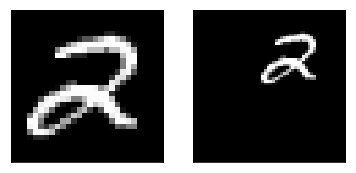

In [6]:
pt,idx = plot_ovt(DL,cmap='gray')

In [7]:
# trainer.build_model()
trainer.compile_model()
z_encoder = Model(trainer.E.input,trainer.z_lat)
classifier = Model(trainer.E.input,trainer.y_class)

In [8]:
from keras.utils import to_categorical
RF = to_categorical(np.ones(len(DL.sx_train)),num_classes=2)

In [10]:
trainer.go(x=DL.sx_train,
           y={'class':DL.y_train_oh,'D':RF,'G':DL.sx_train},
           validation_split=0.05,
           verbose=0)

Epoch        G_loss      val_G_loss  val_class_acc
0:           162.5936    83.1471     0.099       
1:           69.5764     85.4507     0.1143      
2:           52.0531     72.9372     0.2957      
3:           45.4832     53.5711     0.4667      
4:           41.7672     43.2336     0.604       
5:           39.2355     38.956      0.677       
6:           37.1896     37.0939     0.7183      
7:           35.6577     35.2948     0.7507      
8:           34.3585     34.3965     0.7667      
9:           33.0191     33.2785     0.7943      
10:          31.9306     32.3999     0.799       
11:          30.963      31.7898     0.8053      
12:          30.1742     30.2979     0.8043      
13:          28.9699     30.1024     0.796       
14:          28.1798     28.6945     0.8007      
15:          27.2923     28.2803     0.8047      
16:          26.6795     28.2728     0.7987      
17:          25.797      26.6025     0.8003      
18:          25.1974     26.7456     0.8         

In [ ]:
# DL = Shifted_Data_Loader(dataset=config.dataset,flatten=True,
#                          rotation=0.25,
#                          translation=0.9,
#                         )

In [ ]:
hist_df = pd.DataFrame.from_records(trainer.model.history.history)
hist_df.head()

In [ ]:
sns.set_context('paper')
metrics = ['loss','G_loss','class_acc']
fig,axs = plt.subplots(nrows=len(metrics),sharex=True,figsize=(5,10))
for metric_name,ax in zip(metrics,axs):
    sns.scatterplot(data=hist_df[[metric_name,'val_'+metric_name]],ax=ax)

In [ ]:
if not config.dev_mode:
    trainer.save_model()

In [ ]:
from keras.models import Model
from keras.layers import Input

In [ ]:
generator = trainer.G

In [ ]:
trainer.y_class

In [ ]:

# decoder_inp = Input(shape=(config.y_dim+config.z_dim,))
# dec_layers = trainer.model.layers[-(1+(5*2)):]
# print(dec_layers)
# _gen_x = dec_layers[0](decoder_inp)
# l = dec_layers[1]
# isinstance(l,keras.layers.core.Reshape)
# F = None
# for l in dec_layers[1:]:
#     print(type(l))
    
#     if isinstance(l,keras.layers.merge.Add):
#         _gen_x = l([F,_gen_x])
#     else:
#         _gen_x = l(_gen_x)
    
#     if isinstance(l,keras.layers.convolutional.Conv2DTranspose):
#         if l.kernel_size==(1,1):
#             F = _gen_x
            
# # generator = Model(decoder_inp,_gen_x)

In [ ]:
classifier.summary()

In [ ]:
DL.y_test_oh.shape

In [ ]:
classifier.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
classifier.evaluate(DL.sx_test,DL.y_test_oh,batch_size=config.batch_size)

In [ ]:
z_enc = z_encoder.predict(DL.sx_test,batch_size=config.batch_size)
y_class = classifier.predict(DL.sx_test,batch_size=config.batch_size)

In [ ]:
_lat_vec = np.concatenate([y_class,z_enc],axis=1)
_lat_vec.shape

In [ ]:
regen = generator.predict(_lat_vec,batch_size=config.batch_size)

In [ ]:
rand_im = np.random.randint(0,10000)
plt.imshow(regen[rand_im].reshape(56,56),cmap='gray')

In [ ]:
from src.plot import remove_axes

In [ ]:
enc_dec_samples(DL.x_test,DL.sx_test,z_enc,y_class,generator)
plt.tight_layout()

In [ ]:
from src.metrics import var_expl
dxs = DL.dx[1]-14
dys = DL.dy[1]-14
dtheta = DL.dtheta[1]
fve_dx = var_expl(features=z_enc,cond=dxs,bins=21)
fve_dy = var_expl(features=z_enc,cond=dys,bins=21)
fve_dt = var_expl(features=z_enc,cond=dtheta,bins=21)

In [ ]:
fve_dx_norm = np.nan_to_num((dxs.var()-fve_dx)/dxs.var())
fve_dy_norm = np.nan_to_num((dys.var()-fve_dy)/dys.var())
fve_dth_norm = (dtheta.var()-fve_dt)/dtheta.var()

In [ ]:
import seaborn as sns
sns.set_context('talk')

In [ ]:
fve_dx_norm.shape

In [ ]:
sns.scatterplot(x=fve_dx_norm.mean(axis=0),y=fve_dy_norm.mean(axis=0),hue=np.arange(config.z_dim))
plt.xlabel('fve_dx')
plt.ylabel('fve_dy')
# plt.ylim(-0.125,0.25)
xdim = np.argmax(fve_dx_norm.mean(axis=0))

In [ ]:
fve_dx_norm.mean(axis=0)

In [ ]:
plt.scatter(np.arange(config.z_dim),fve_dy_norm.mean(axis=0))
plt.xlabel('Z_n')
plt.ylabel('fve_dy')
# plt.ylim(-0.125,0.25)
ydim = np.argmax(fve_dy_norm.mean(axis=0))
print(ydim)

In [ ]:
plt.scatter(np.arange(config.z_dim),fve_dth_norm.mean(axis=0))
plt.xlabel('Z_n')
plt.ylabel('fve_dtheta')
# plt.ylim(0.0,0.5)
np.argmax(fve_dth_norm.mean(axis=0))

In [ ]:
from src.plot import Z_color_scatter
Z_color_scatter(z_enc,[xdim,ydim],DL.y_test)

In [ ]:
from src.plot import Z_color_scatter
Z_color_scatter(z_enc,[2,ydim],dxs)
# plt.ylim(-3,3)
# plt.xlim(-3,3)

In [ ]:
outl = z_enc[:,4]>5
plt.imshow(DL.sx_test[outl][np.random.randint(0,97)].reshape(56,56),cmap='gray')

In [ ]:
Z_color_scatter(z_enc,[xdim,ydim],dys)
# plt.ylim(-3,3)
# plt.xlim(-3,3)

In [ ]:
z_enc.shape

In [ ]:
sns.jointplot(dtheta,z_enc[:,4])

In [ ]:
Z_color_scatter(z_enc,[xdim,ydim],dtheta)

In [ ]:
from plt.